In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import inf
import math

In [2]:
# 从脚本中导入数据
from race1 import *

In [3]:
# 保存文件
save_file = 'UCI_save_Sprinter.csv'

In [4]:
# 读取赛道的数据
import pandas as pd

data = pd.read_csv('UCI_grad.csv')
data.shape

(490, 6)

In [5]:
data.tail()

,Unnamed: 0,DistanceMeters,AltitudeMeters,DistanceDiff,AltitudeDiff,Gradient
485,485,30258.496621,9.29,78.518889,1.88,0.023943
486,486,30268.609849,9.29,10.113228,0.00,0.000000
487,487,30303.174870,8.96,34.565020,-0.33,-0.009547
488,488,30339.122420,8.87,35.947551,-0.09,-0.002504
489,489,30369.820594,8.87,30.698174,0.00,0.000000


In [6]:
# 计算S
S = data.iloc[-1, 1]
S

30369.82059436561

In [7]:
data.head()

,Unnamed: 0,DistanceMeters,AltitudeMeters,DistanceDiff,AltitudeDiff,Gradient
0,0,0.000000,3.02,NaN,NaN,NaN
1,1,29.476700,5.16,29.476700,2.14,0.072600
2,2,64.900044,8.83,35.423344,3.67,0.103604
3,3,136.189296,8.80,71.289252,-0.03,-0.000421
4,4,204.170475,8.82,67.981179,0.02,0.000294


## 海拔图

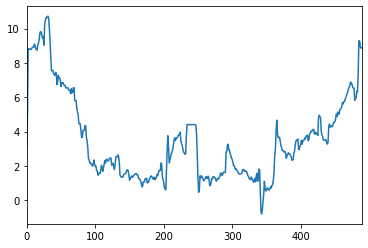

In [8]:
data['AltitudeMeters'].plot()

In [9]:
data['DistanceDiff'].value_counts().sort_index()

0.000000     2
3.561635     1
4.451827     1
4.663875     1
4.664113     1
            ..
99.077840    1
99.104297    1
99.104323    1
99.536110    1
99.605305    1
Name: DistanceDiff, Length: 487, dtype: int64

In [10]:
# 将数据离散化
dS = 10
S_max = math.floor(S / dS) * dS
num_s = int(S_max / dS) + 1
num_v = 50
num_w = 100
v = np.linspace(v_min, v_max, num_v)
w = np.linspace(0, w_max, num_w)
s = np.linspace(0, S_max, num_s)
len(v), len(w), len(s)

(50, 100, 3037)

In [11]:
S_max

30360

In [12]:
dis_iter = 0
grad = np.zeros(num_s)

for s_iter in range(num_s):
    s_cur = dS * s_iter
    if data.iloc[dis_iter, 1] < s_cur:
        dis_iter += 1
    grad[s_iter] = data.iloc[dis_iter, -1]

grad[0:5]    

array([       nan, 0.07259971, 0.07259971, 0.103604  , 0.103604  ])

In [13]:
grad[-5:-1]

array([-0.00250365, -0.00250365,  0.        ,  0.        ])

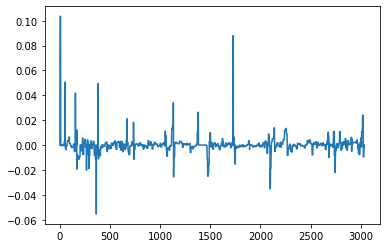

In [14]:
grad[0] = 0
plt.plot(grad)

In [15]:
max(grad)

0.1036039950407054

In [16]:
max(data.loc[1:, 'AltitudeDiff'])

3.67

In [17]:
max(data.loc[1:, 'DistanceDiff'])

99.60530547601776

## 计算theta

In [18]:
# 计算theta
theta = np.zeros(num_s)

for g_iter, g in enumerate(grad):
    theta[g_iter] = math.atan(g)

# 
#
theta *= 10


theta[0:5]

array([0.        , 0.72472566, 0.72472566, 1.03235676, 1.03235676])

In [19]:
max(theta) * 180 / np.pi

59.14968555948231

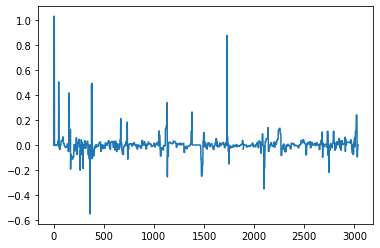

In [20]:
plt.plot(theta)

In [21]:
# 设定初始状态
state0 = '0,' + str(num_w - 1)
state0

'0,99'

## 计算功率策略

In [22]:
# 定义4种功率计算的策略
def U_strategy(category, **kwargs):
    """
    Umax(vi, wi)
    Ua0(vi, theta)
    Ucp()
    U0()
    """
    if category == 'Umax':
        return Umax(kwargs['vi'], kwargs['wi'])
    if category == 'Ua0':
        return Ua0(kwargs['vi'], kwargs['wi'], kwargs['theta'])
    if category == 'Ucp':
        return Ucp()
    if category == 'U0':
        return U0()
    assert 0

# Umax
def Umax(vi, wi):
    coef = 0.04
    # return (0.8 * wi + CP) * (vi / (30 + coef * wi) ) * (1 - vi / (30 + coef * wi)) * 3.2
    return 7e-6 * wi**2 + 0.0023 * wi + CP

# Ua=0
def Ua0(vi, wi, theta):
    # return (gravity * (math.sin(theta) + mu * math.cos(theta)) + 0.5 * Cd * rho * A * vi**2 / mass) * mass * vi
    res = (0.12 * gravity * (math.sin(theta) + mu * math.cos(theta)) + 0.03 * vi**2 / mass) * mass * vi
    return min(res, Umax(vi, wi))

def Ucp():
    return CP

def U0():
    return 0

In [23]:
# 10m/s时U = 600, a = 0
v10 = 10
# gravity * (math.sin(0) + mu * math.cos(0)) + arg * v10**2 / mass ==  Umax(0, w_max) / (mass * v10)
arg = (Umax(0, w_max) / (mass * v10) - gravity * (math.sin(0) + mu * math.cos(0))) * mass / (v10**2)
arg

-1.7693454929999999

In [24]:
wi = 600
vi = 10
Umax(vi, wi), Ua0(vi, wi, 0.02)

(208.5, 208.5)

In [25]:
# 最大的Umax
vi = 16
Umax(vi, CP), Umax(vi, w_max)

(205.36360811999998, 620.874507)

204.6

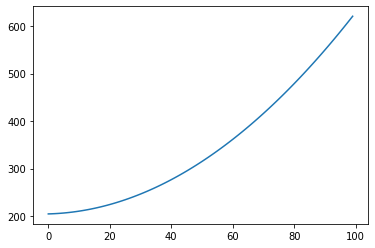

In [26]:
li = []
for wi in w:
    li.append(Umax(12, wi))

plt.plot(li)
Umax(1, 0)

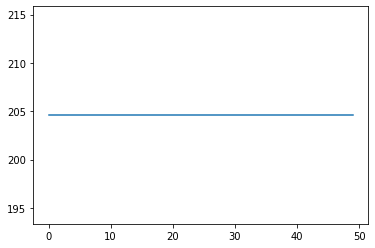

In [27]:
li = []
for vi in v:
    li.append(Umax(vi, 0))

plt.plot(li)

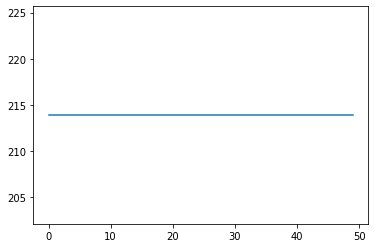

In [28]:
li = []
for vi in v:
    li.append(Umax(vi, 1000))

plt.plot(li)

In [29]:
def get_nearest(val, arr):
    """在arr中找到和val最接近的值的下标"""
    arr = np.array(arr)
    sub = abs(arr - val)
    ind = np.argmin(sub)
    return ind

arr = [1, 2, 3, 4, 5]
val = 3.8
arr[get_nearest(val, arr)]

4

In [30]:
def get_vw(key):
    """根据字典键值返回v,w"""
    v_ind, w_ind = key.split(',')
    return v[int(v_ind)], w[int(w_ind)]

## 计算下一个速度

In [31]:
def cal_v_next(vi, ui, theta):
    """计算下一个时间的速度"""
    res = vi + dS / vi * (ui / (mass * vi) - gravity * (math.sin(theta) + mu * math.cos(theta)) - 0.5 * Cd * rho * A * vi**2 / mass)
    # a = 1.5* ui / (mass * vi) - gravity * (math.sin(theta) + mu * math.cos(theta)) -1.67 * vi**2 / mass
    # print(a)
    # res = vi + 0.1 * dS / vi * a
    res = (0.0008 * ui + 0.5154) * (-0.0058 * vi**2 + 0.9526 * vi + 1.5625) - 0.1 * gravity * (math.sin(theta) + mu * math.cos(theta))
    return res + 2
    

In [32]:
t = np.pi * 5 / 180

gravity * (math.sin(t) + mu * math.cos(t))

3.7829386913167826

In [33]:
0.5 * Cd * rho * A

0.09675

In [34]:
# 计算：10m/s时，受力达到平衡
v10 = 10
# Umax(0, w_max) / (mass * v10) == gravity * (math.sin(0) + mu * math.cos(0)) - arg * v10**2 / mass
arg = -(gravity * (math.sin(0) + mu * math.cos(0)) + Umax(0, w_max) / (mass * v10)) * mass / v10**2
arg

-3.0110945069999997

In [35]:
cal_v_next(3, 700, 0)

6.403454740000001

6.8691897

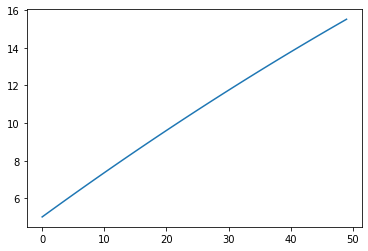

In [36]:
li = []

for vi in v:
    li.append(cal_v_next(vi, 300, 0))

plt.plot(li)

cal_v_next(5, 400, 0)

4.6052452200000005

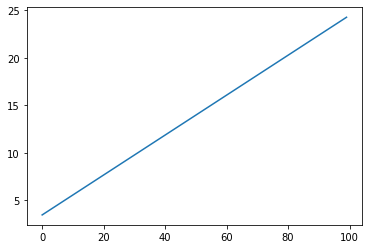

In [37]:
li = []

for wi in w:
    li.append(cal_v_next(2, wi, 0))

plt.plot(li)

ta = np.pi * 30 / 180
cal_v_next(1, 800, 0)

## 计算下一个W

In [38]:
def cal_w_next(vi, wi, ui):
    """计算下一个时间的无氧功"""
    if ui >= CP:
        return wi + dS / vi * (CP - ui)
    else:
        a = 0.11
        b = 237.5
        return wi + dS / vi * (CP - a * ui - b)

In [39]:
def clamp(val, limit1, limit2):
    if limit1 < limit2:
        minV, maxV = limit1, limit2
    else:
        minV, maxV = limit2, limit1
    
    if val < minV:
        return minV
    elif val > maxV:
        return maxV
    else:
        return val


In [40]:
S

30369.82059436561

## 计算所有转移状态

In [41]:
# next_state[s_ind]['v_ind,w_ind']代表当前的s对应的行状态为(v, w)的下一个状态的v', w'
# next_state长度为num_s, 最后一个（S_max）没有值（即下一个状态），只有键（即当前状态）
next_state = []
for i in range(num_s):
    next_state.append({})

# 初始化v和w
next_state[0][state0] = []
len(next_state)

# categories = ['Umax', 'Ucp', 'U0']
categories = ['Umax', 'Ua0', 'Ucp', 'U0']

# theta = np.pi * 30 / 180
# 为next_state生成所有可能的状态
for s_iter in range(num_s - 1):
    for cur_st in next_state[s_iter].keys():
        # 生成4种全新的状态
        v_cur, w_cur = get_vw(cur_st)
        # 计算v_next, w_next
        args = [{'vi':v_cur, 'wi':w_cur}, {'vi':v_cur, 'wi':w_cur, 'theta':theta[s_iter]}, {}, {}]
        # args = [{'vi':v_cur, 'wi':w_cur}, {}, {}]
        for cat, arg in zip(categories, args):
            u_cur = U_strategy(cat, **arg)
            v_next = cal_v_next(v_cur, u_cur, theta[s_iter])
            w_next = cal_w_next(v_cur, w_cur, u_cur)

            v_next_ind = get_nearest(v_next, v)
            w_next_ind = get_nearest(w_next, w)
            # 添加到下一层的next_state
            k = ','.join([str(v_next_ind), str(w_next_ind)])
            
            next_state[s_iter][cur_st].append(k)
            if k not in next_state[s_iter + 1].keys():
                next_state[s_iter + 1][k] = []

len(next_state[10])

759

## 前向DP(舍弃的方法)

In [42]:
def DP_forward():
    # 开始动态规划
    # 初始化损失函数J，J代表每个位置到终点的最短时间
    J = []
    for i in range(num_s):
        J.append({})

    J[0][state0] = 0


    # 最大迭代次数
    max_iter = 500
    cur_iter = 0
    last_J = 0

    while cur_iter < max_iter:
        best_stats = [state0]
        best_modes = []

        # 对每一层进行遍历
        for s_iter in range(num_s - 1):
            cost_min_s = inf    # 该距离下的最小时间
            best_stat_s = 0     # 该距离下的最好状态
            best_mode_s = 0     # 该距离下的u模式选择

            for cur_st, next_stats in next_state[s_iter].items():
                # 获得当前的状态
                v_cur, w_cur = get_vw(cur_st)
                # 当前状态转移得到的4种新状态中时间最短的
                cost_min = inf
                best_stat = 0
                best_mod = 0
                # 对于每一个转移后的状态，计算所用的时间
                for mode_ind, next_st in enumerate(next_stats):
                    v_next, w_next = get_vw(next_st)

                    # 计算dS路程内花费的平均时间
                    dt = dS / (v_cur + v_next)
                    cost = dt
                    if next_st in J[s_iter + 1].keys():
                        cost += J[s_iter + 1][next_st]

                    if cost < cost_min:
                        cost_min = cost
                        best_stat = next_st
                        best_mod = mode_ind
                
                J[s_iter][cur_st] = cost_min

                if cost_min < cost_min_s:
                    cost_min_s = cost_min
                    best_stat_s = best_stat
                    best_mode_s = best_mod
            
            # 记录选择的状态
            best_stats.append(best_stat_s)
            best_modes.append(best_mode_s)
            
        cur_iter += 1
        if (cur_iter + 1) % 10 == 0:
            print('iter: ', cur_iter + 1, J[0][state0])

        if abs(last_J - J[0][state0]) < 1e-3:
            print('iter: ', cur_iter + 1, J[0][state0])
            break
        last_J = J[0][state0]

In [43]:
# 最大距离能够得到的状态
len(next_state[num_s - 1].keys())

1472

## 后向DP

In [44]:
# 动态规划方法2
J = []
for i in range(num_s):
    J.append({})

# 初始化终点的值
for key in next_state[num_s - 1].keys():
    J[num_s - 1][key] = 0

# 记录每个状态选择的模式，最后一个状态不选择
best_modes = []
for i in range(num_s - 1):
    best_modes.append({})

for s_iter in range(num_s - 2, -1, -1): 
    for cur_st, next_stats in next_state[s_iter].items():
        # 获得当前的状态
        v_cur, w_cur = get_vw(cur_st)
        # 当前状态转移得到的4种新状态中时间最短的
        cost_min = inf
        best_mod = 0
        # 对于每一个转移后的状态，计算所用的时间
        for mode_ind, next_st in enumerate(next_stats):
            v_next, w_next = get_vw(next_st)
            # 计算dS路程内花费的平均时间
            dt = dS / (v_cur + v_next)
            cost = dt
            # if next_st in J[s_iter + 1].keys():
            Ji = J[s_iter + 1][next_st]
            cost += Ji

            if cost < cost_min:
                cost_min = cost
                best_mod = mode_ind
        
        J[s_iter][cur_st] = cost_min
        best_modes[s_iter][cur_st] = best_mod

In [45]:
J[0]

{'0,99': 1971.800745539907}

In [46]:
# 通过每个状态选择的模式推导出最优状态及其功率
cur_st = state0

v0, w0 = get_vw(state0)
# 统计v
v_best = [v0]

# 统计w
w_best = [w0]

# 统计u
u_best = []

# 统计mode
mode_best = []
# categories = ['Umax', 'Ua0', 'Ucp', 'U0']

for s_iter in range(num_s - 1):
    mode_ind = best_modes[s_iter][cur_st]
    mode_best.append(mode_ind)
    # 得到下一个状态
    next_st = next_state[s_iter][cur_st][mode_ind]
    v_next, w_next = get_vw(next_st)
    v_best.append(v_next)
    w_best.append(w_next)

    args = [{'vi':v_next, 'wi':w_next}, {'vi':v_next, 'wi':w_next, 'theta':theta[s_iter]}, {}, {}]
    # args = [{'vi':v_next, 'wi':w_next}, {}, {}]
    u_next = U_strategy(categories[mode_ind], **args[mode_ind])
    u_best.append(u_next)
    cur_st = next_st


In [47]:
Umax_best = []
for vi, wi in zip(v_best, w_best):
    Umax_best.append(Umax(vi, wi))

## 根据速度计算的时间

In [48]:
sum_t = 0
for vi in v_best:
    sum_t += dS / vi
print('min t: ', sum_t, 's', sum_t / 60, 'min')

min t:  3947.391008594559 s 65.78985014324265 min


## 数据保存


In [49]:
len(v_best), len(w_best), len(u_best), len(Umax_best), len(mode_best)

(3037, 3037, 3036, 3037, 3036)

In [50]:
save_data = pd.DataFrame({'distance':s, 'speed':v_best, 'w':w_best, 'u':[u_best[0]] + u_best, 'Umax':Umax_best, 'Umode':[mode_best[0]] + mode_best})
save_data.shape

(3037, 6)

In [51]:
save_data.head()

,distance,speed,w,u,Umax,Umode
0,0.0,3.000000,7549.0,204.6,620.874507,2
1,10.0,4.734694,7549.0,204.6,620.874507,2
2,20.0,5.081633,7549.0,204.6,620.874507,2
3,30.0,5.428571,7549.0,204.6,620.874507,2
4,40.0,5.428571,7549.0,204.6,620.874507,2


In [52]:
save_data['Umode'].value_counts()

0    2992
2      23
1      22
Name: Umode, dtype: int64

In [53]:
tmp = np.zeros(save_data.shape[0])
tmp[0] = sum_t

save_data['Time'] = tmp
save_data.head()

,distance,speed,w,u,Umax,Umode,Time
0,0.0,3.000000,7549.0,204.6,620.874507,2,3947.391009
1,10.0,4.734694,7549.0,204.6,620.874507,2,0.000000
2,20.0,5.081633,7549.0,204.6,620.874507,2,0.000000
3,30.0,5.428571,7549.0,204.6,620.874507,2,0.000000
4,40.0,5.428571,7549.0,204.6,620.874507,2,0.000000


In [54]:
save_data.to_csv(save_file)

## 速度图

Text(0.5, 1.0, 'Speed Curve')

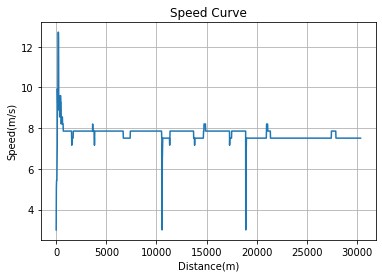

In [55]:
plt.plot(s, v_best)
plt.grid(True)
plt.box(True)
plt.xlabel('Distance(m)')
plt.ylabel('Speed(m/s)')
plt.title('Speed Curve')



In [56]:
def fill_li(li, interval):
    if type(li) == list:
        li_fill = li + [0] * (math.ceil(len(li) / interval) * interval - len(li))
    else:
        li_fill = li[:]
    return np.reshape(li_fill, (-1, interval))

In [57]:
interval = 40

In [58]:
v_best_fill = fill_li(v_best, interval)

In [59]:
v_best_fill.shape

(76, 40)

In [60]:
mean_v_best = v_best_fill.mean(axis=1)
mean_v_best[0:5]

array([8.68112245, 8.53367347, 7.85714286, 7.7877551 , 7.77040816])

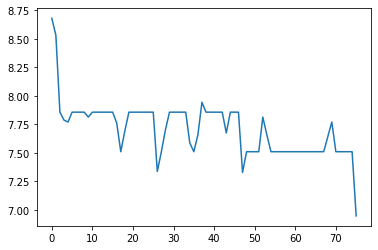

In [61]:
plt.plot(mean_v_best);

In [62]:
pd.Series(v_best).value_counts()

7.857143     1585
7.510204     1332
8.204082       37
8.551020       13
7.163265       12
9.591837       11
9.244898       10
8.897959        7
5.428571        5
12.714286       4
6.469388        3
4.734694        3
6.816327        3
3.000000        3
5.775510        2
12.020408       1
5.081633        1
6.122449        1
10.285714       1
10.979592       1
9.938776        1
12.367347       1
dtype: int64

## W图

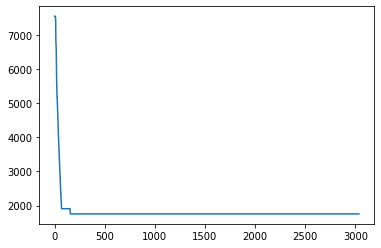

In [63]:
plt.plot(w_best)

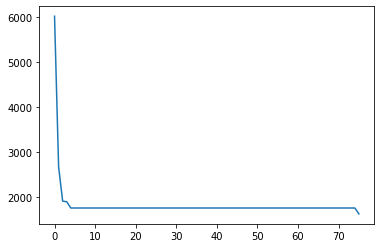

In [64]:
w_best_fill = fill_li(w_best, interval)
mean_w_best = w_best_fill.mean(axis=1)
plt.plot(mean_w_best)

## U图

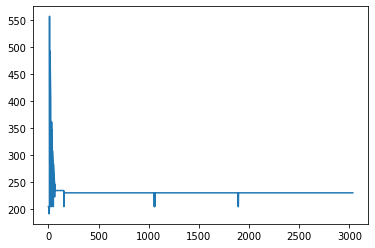

In [65]:
plt.plot(u_best)

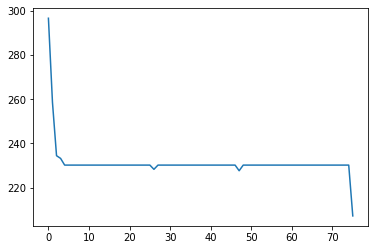

In [66]:
u_best_fill = fill_li(u_best, interval)
mean_u_best = u_best_fill.mean(axis=1)
plt.plot(mean_u_best)

## Umax图

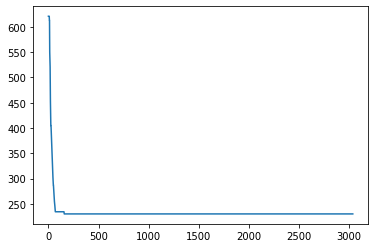

In [67]:
plt.plot(Umax_best)

## Mode图

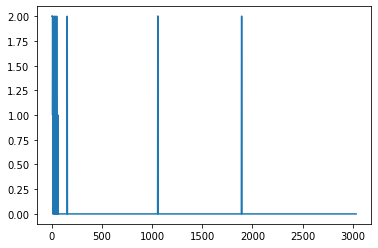

In [68]:
plt.plot(mode_best)

In [69]:
mode_interval = 10
mode_best_fill = fill_li(mode_best, mode_interval)
mode_best_fill.shape

(304, 10)

In [70]:
mode_best_fill[:5,:]

array([[2, 2, 2, 2, 2, 2, 2, 2, 1, 2],
       [2, 0, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 2, 2, 1, 1, 1, 1],
       [1, 1, 0, 1, 2, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 2]])

In [71]:
pd.Series(mode_best_fill[0,:].flat).value_counts().sort_values()

1    1
2    9
dtype: int64

In [72]:
# 获取数组中数量最多的值
pd.Series(mode_best_fill[4,:].flat).value_counts().sort_values().index.values[-1]

0

In [73]:
# 统计interval中最多mode的数目
cnt_mode_best = np.zeros(mode_best_fill.shape[0])
for row_iter in range(mode_best_fill.shape[0]):
    cnt_mode_best[row_iter] = pd.Series(mode_best_fill[row_iter,:].flat).value_counts().sort_values().index.values[-1]

In [74]:
cnt_mode_best.shape

(304,)

In [75]:
cnt_mode_best[0:8]

array([2., 1., 1., 1., 0., 0., 0., 0.])

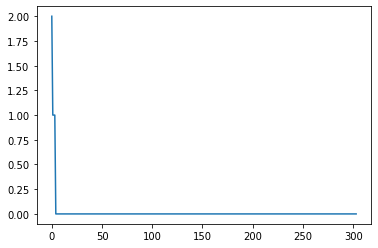

In [76]:
plt.plot(cnt_mode_best)

In [77]:
mode_best[0:10]

[2, 2, 2, 2, 2, 2, 2, 2, 1, 2]

In [78]:
pd.Series(mode_best).value_counts()

0    2992
1      22
2      22
dtype: int64

In [79]:
v_best[0:10]

[3.0,
 4.73469387755102,
 5.081632653061225,
 5.428571428571429,
 5.428571428571429,
 5.428571428571429,
 5.428571428571429,
 5.428571428571429,
 6.122448979591837,
 6.469387755102041]

In [80]:
u_best[:10]

[204.6,
 204.6,
 204.6,
 204.6,
 204.6,
 204.6,
 204.6,
 204.6,
 191.0774745177937,
 204.6]

In [81]:
w_best[-1]

1753.8080808080806

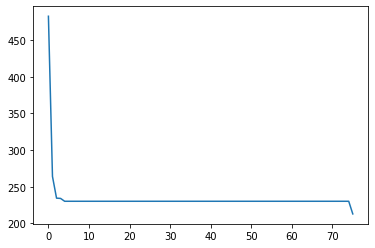

In [82]:
Umax_best_fill = fill_li(Umax_best, interval)
mean_Umax_best = Umax_best_fill.mean(axis=1)
plt.plot(mean_Umax_best)

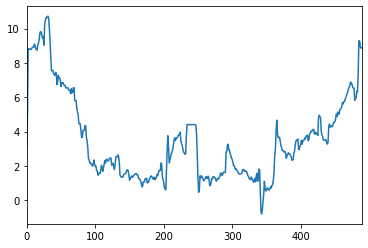

In [83]:
data['AltitudeMeters'].plot()

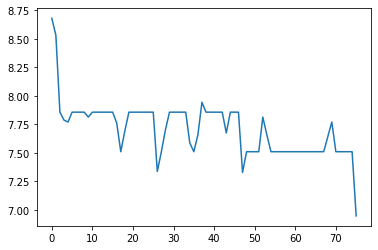

In [84]:
plt.plot(mean_v_best)

In [85]:
## 使用最优的U来计算速度，继而计算最短时间
v_simu = [v_min]

for ui in u_best:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-85-be4d4dbe38db>, line 5)